In [ ]:
# !pip install caas_jupyter_tools

ERROR: Could not find a version that satisfies the requirement caas_jupyter_tools (from versions: none)
ERROR: No matching distribution found for caas_jupyter_tools



# Transformer Inference Compute Estimates (KV-Cache)

This notebook walks from basic matrix-multiplication complexity to practical, closed-form estimates for **per-token** compute and **time** during autoregressive decoding with **KV-cache**. It includes:

1. A quick refresher on matrix multiplication FLOPs.
2. Per-layer FLOPs for a Transformer block with and without KV-cache.
3. A server-level compute model with **fixed token budget** $(P = S\cdot L)$ (concurrent requests \(S\), context length \(L\)).
4. Plots of total **time per new decoded token** vs. \(L\) and \(S\) for a given GPU peak FLOPs.



## 1) Matrix multiplication complexity (short refresher)

Multiplying an \((m \times n)\) matrix by an \((n \times p)\) matrix costs approximately:

$$
\text{FLOPs} \approx 2\,m\,n\,p
$$

(counting a multiply and an add as two FLOPs). This is the core building block behind linear layers in Transformers.



## 2) Transformer per-layer FLOPs

We separate each Transformer layer into **attention** and **FFN** parts. Let:

- \(L\): sequence length / context length (number of tokens attended over).
- \(d\): hidden size.
- \(h\): number of attention heads (each head size $(d_h = d/h)$).
- \(r\): FFN expansion ratio (usually $(r \approx 4$)).

### 2.1) Without KV-cache (full recomputation)
Processing a length-\(L\) sequence **per layer** costs approximately:

$$
\underbrace{8Ld^2}_{Q,K,V,O \text{ projections}} \;+\; \underbrace{4L^2 d}_{QK^\top \text{ and weights}\times V} \;+\; \underbrace{4rLd^2}_{\text{FFN}}
\;=\; (8+4r)Ld^2 \;+\; 4L^2 d.
$$


### 2.2) With KV-cache (incremental decode, per **new token**)
Only the new token's attention is computed (past keys/values are reused). Per layer, per new token:

$$
\underbrace{8d^2}_{Q,K,V,O \text{ for the new token}} \;+\; \underbrace{4Ld}_{qK^\top \text{ and weights}\times V} \;+\; \underbrace{4rd^2}_{\text{FFN}}
\;=\; (8+4r)d^2 \;+\; 4Ld.
$$


We will use this last expression as our **per-request, per-layer, per-token** FLOPs for decoding with KV-cache.



## 3) Server-level model with fixed token budget $(P = S\cdot L)$

Let:
- $S$: number of concurrent requests (each decoding one new token at a step).
- $P = S \cdot L$: fixed "token budget" across the server at each decoding step.

Then total **per-layer** FLOPs across all \(S\) requests is:

$$
\big((8+4r)d^2 + 4Ld\big)\,S
\;=\;
\frac{P(8+4r)d^2}{L} \;+\; 4Pd.
$$


This exhibits a \(1/L\) term plus a constant \(2Pd\) asymptote.

For the full model with $n_\text{layers}$ layers, multiply by $n_\text{layers}$. To convert to **time per token**, divide by **GPU peak FLOPs/sec**.



## 4) Parameters

We define the following parameters in code:

- `r` — FFN expansion ratio (default: 4).
- `d` — hidden size (default: 4096).
- `P` — fixed token budget $P=S\cdot L$ (default: 20,000).
- `n_layers` — number of Transformer layers (default: 64).
- `gpu_flops_per_sec` — GPU peak FLOPs/sec (default: 312e12 for NVIDIA A100 ~312 TFLOPS).

You can adjust these to match your setup.


In [ ]:

# Parameters (adjust as needed)
r = 4
d = 4096
P = 20000
n_layers = 64
gpu_flops_per_sec = 312e12  # A100 FP16/BF16 peak ~312 TFLOPS



## 5) Functions for FLOPs and time
We implement small helpers for clarity and reuse.


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def per_request_per_layer_flops_kv(L, d, r):
    """Per-request, per-layer, per new token FLOPs with KV-cache: (4+2r)d^2 + 2Ld."""
    return (8 + 4*r) * d**2 + 4 * L * d

def server_total_per_layer_flops(L, P, d, r):
    """Total per-layer FLOPs across S requests, with fixed P=S*L: P*((4+2r)d^2)/L + 2*P*d."""
    return P * ((8 + 4*r) * d**2) / L + 4 * P * d

def server_total_model_flops(L, P, d, r, n_layers):
    """Total model FLOPs across S requests (per token step)."""
    return server_total_per_layer_flops(L, P, d, r) * n_layers

def time_per_token_L(L, P, d, r, n_layers, gpu_flops_per_sec):
    """Time per new decoded token as a function of L with P fixed (seconds)."""
    flops = server_total_model_flops(L, P, d, r, n_layers)
    return flops / gpu_flops_per_sec

def time_per_token_S(S, P, d, r, n_layers, gpu_flops_per_sec):
    """Time per new decoded token as a function of S with P fixed (seconds).
    Using L = P / S to keep P constant.
    """
    L = P / S
    return time_per_token_L(L, P, d, r, n_layers, gpu_flops_per_sec)
    # return (n_layers / gpu_flops_per_sec) * (((4 + 2*r) * d**2) * S + 2 * P * d)



## 6) Plot: Time per token vs. \(L\) (with fixed \(P\))

This plots $(T(L) = \dfrac{n_\text{layers}}{\text{GPU}}\left(\dfrac{P(8+4r)d^2}{L} + 4Pd\right))$ and the asymptote $(\dfrac{n_\text{layers} 4Pd}{\text{GPU}})$.


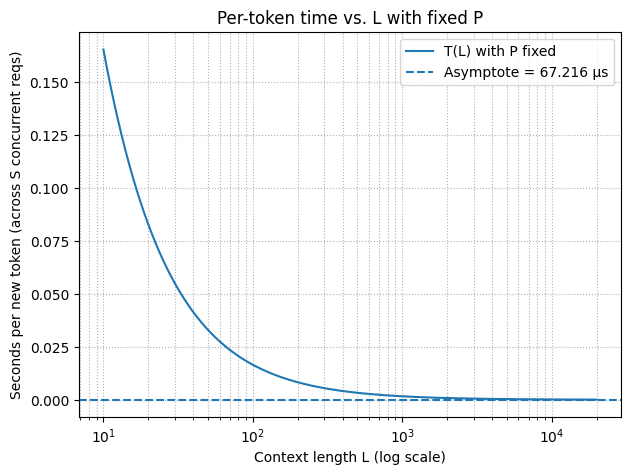

In [ ]:

L_vals = np.logspace(np.log10(10), np.log10(P), 400)
T_L = time_per_token_L(L_vals, P, d, r, n_layers, gpu_flops_per_sec)
asymptote_time = (4 * P * d * n_layers) / gpu_flops_per_sec

plt.figure(figsize=(7,5))
plt.plot(L_vals, T_L, label="T(L) with P fixed")
plt.axhline(asymptote_time, linestyle="--",
            label=f"Asymptote = {asymptote_time*1e6:.3f} µs")
plt.xscale("log")
plt.xlabel("Context length L (log scale)")
plt.ylabel("Seconds per new token (across S concurrent reqs)")
plt.title("Per-token time vs. L with fixed P")
plt.grid(True, which="both", linestyle=":")
plt.legend(loc="best")
plt.show()



## 7) Combined plot: \(T(L)\) and \(T(S)\) on the same figure

- Bottom x-axis: \(L\) (log scale).
- Top x-axis: \(S\) (linear), related by \(S = P / L\).


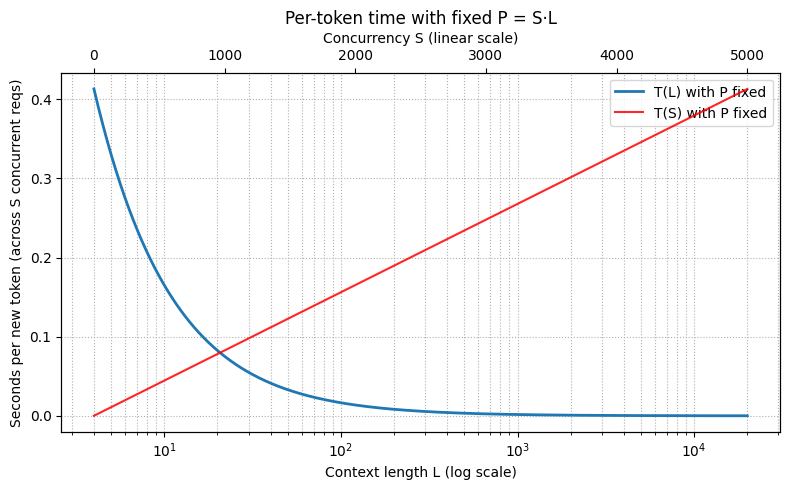

In [ ]:

S_vals = np.linspace(1, 5000, 600)
T_S = time_per_token_S(S_vals, P, d, r, n_layers, gpu_flops_per_sec)

L_vals = np.logspace(np.log10(max(4, P/5000)), np.log10(P), 600)
T_L = time_per_token_L(L_vals, P, d, r, n_layers, gpu_flops_per_sec)

fig, axL = plt.subplots(figsize=(8,5))
axL.plot(L_vals, T_L, label="T(L) with P fixed", linewidth=2)
axL.set_xscale("log")
axL.set_xlabel("Context length L (log scale)")
axL.set_ylabel("Seconds per new token (across S concurrent reqs)")
axL.grid(True, which="both", linestyle=":")

axS = axL.twiny()
axS.plot(S_vals, T_S, label="T(S) with P fixed", alpha=0.85, color='red')
axS.set_xlabel("Concurrency S (linear scale)")

lines_L, labels_L = axL.get_legend_handles_labels()
lines_S, labels_S = axS.get_legend_handles_labels()
axL.legend(lines_L + lines_S, labels_L + labels_S, loc="upper right")

plt.title("Per-token time with fixed P = S·L")
plt.tight_layout()
plt.show()


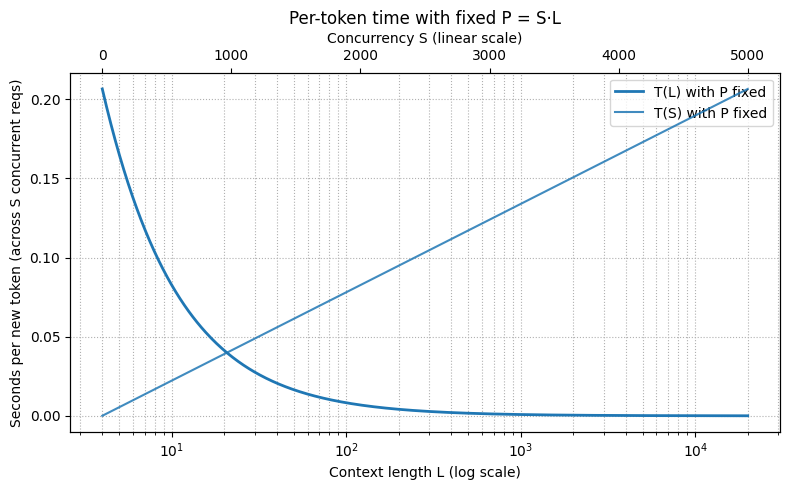

In [ ]:
# testing
# S_vals = np.linspace(5000, 1, 600)
# T_S = time_per_token_S(S_vals, P, d, r, n_layers, gpu_flops_per_sec)

# L_vals = np.logspace(np.log10(max(4, P/5000)), np.log10(P), 600)
# T_L = time_per_token_L(L_vals, P, d, r, n_layers, gpu_flops_per_sec)

# fig, axL = plt.subplots(figsize=(8,5))

# axS = axL.twiny()
# axS.plot(S_vals, T_S, label="T(S) with P fixed", alpha=0.85)
# axS.set_xlabel("Concurrency S (linear scale)")

# axL.plot(L_vals, T_L, label="T(L) with P fixed", linewidth=2)
# axL.set_xscale("log")
# axL.set_xlabel("Context length L (log scale)")
# axL.set_ylabel("Seconds per new token (across S concurrent reqs)")
# axL.grid(True, which="both", linestyle=":")

# lines_L, labels_L = axL.get_legend_handles_labels()
# lines_S, labels_S = axS.get_legend_handles_labels()
# axL.legend(lines_L + lines_S, labels_L + labels_S, loc="upper right")

# plt.title("Per-token time with fixed P = S·L")
# plt.tight_layout()
# # plt.show()
# # S_vals



## 8) Sample values table

Representative points for \(L\) and \(S\) with the current parameters.


In [ ]:

# from caas_jupyter_tools import display_dataframe_to_user

import pandas as pd
rows = []
for L in [50, 100, 200, 500, 1000, 2000, 4000, 8000, 10000, 20000]:
    S = P / L
    rows.append({
        "L (context)": L,
        "S (concurrency)": S,
        "Time per token (s)": time_per_token_L(L, P, d, r, n_layers, gpu_flops_per_sec),
        "Time per token (ms)": time_per_token_L(L, P, d, r, n_layers, gpu_flops_per_sec)*1e3
    })

for S in [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]:
    L = P / S
    rows.append({
        "S (concurrency)": S,
        "L (context)": L,
        "Time per token (s)": time_per_token_S(S, P, d, r, n_layers, gpu_flops_per_sec),
        "Time per token (ms)": time_per_token_S(S, P, d, r, n_layers, gpu_flops_per_sec)*1e3
    })

df = pd.DataFrame(rows)
# display_dataframe_to_user("Transformer per-token time: sample points", df)
df

,L (context),S (concurrency),Time per token (s),Time per token (ms)
0,50.0,400.0,0.033105,33.105426
1,100.0,200.0,0.016586,16.586321
2,200.0,100.0,0.008327,8.326769
3,500.0,40.0,0.003371,3.371037
4,1000.0,20.0,0.001719,1.719127
5,2000.0,10.0,0.000893,0.893172
6,4000.0,5.0,0.000480,0.480194
7,8000.0,2.5,0.000274,0.273705
8,10000.0,2.0,0.000232,0.232407
9,20000.0,1.0,0.000150,0.149812



# Memory-Bound Estimates for Transformer Decoding (KV-Cache)

This companion notebook focuses **only on memory traffic** for per-token latency estimates during autoregressive decoding with KV-cache.
It is designed to be appended to the previous compute-focused notebook.



## Parameters

- $r$ — FFN expansion ratio (default: 4)  
- $d$ — hidden size (default: 4096)  
- $P$ — fixed token budget $P=S\cdot L$ (default: 20,000)  
- $n_\text{layers}$ — number of Transformer layers (default: 64)  
- `dtype_bytes` — bytes per element (default: 2 for FP16/BF16)  
- `BW` — memory bandwidth in Bytes/sec (e.g., A100-80GB $\approx 2.0\times 10^{12}$, A100-40GB $\approx 1.555\times 10^{12}$)


In [ ]:

# Parameters (adjust as needed)
r = 4
d = 4096
P = 20000
n_layers = 64
dtype_bytes = 2   # FP16/BF16
BW = 1.555e12       # Bytes/sec; for A100-40GB



## Memory Traffic Model

We approximate the per-token memory bytes (across all $S$ concurrent requests at a step) as the sum of:

1. **Weights read (dominant):** $(4+2r)d^2$ params per layer  
   Bytes: $n_\text{layers}\,(4+2r)\,d^2 \cdot \text{dtype_bytes}$

2. **KV-cache read (constant vs $L$ at fixed $P$):** across $S$ requests per layer we read both $K$ and $V$ for past $L$ tokens  
   Elements: $2SLd = 2Pd$  
   Bytes: $n_\text{layers}\,2Pd \cdot \text{dtype_bytes}$

3. **KV-cache write (grows with $S$):** writing new $K,V$ for the new token per request  
   Elements: $2Sd$  
   Bytes: $n_\text{layers}\,2Sd \cdot \text{dtype_bytes}$

4. **Activation I/O (smaller term, but included):** for the six linears (Q,K,V,O and 2xFFN) we use a factor $c_\text{act}=12$  
   Bytes: $n_\text{layers}\,c_\text{act}\,Sd \cdot \text{dtype_bytes}$

The **memory-bound time** is  
$T_\text{memory} = \dfrac{\text{Bytes}}{\text{total_BW}}$.


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def bytes_weights_per_model(d, r, n_layers, dtype_bytes):
    return n_layers * (4 + 2*r) * d**2 * dtype_bytes

def bytes_kv_read_per_model(P, d, n_layers, dtype_bytes):
    return n_layers * (2 * P * d) * dtype_bytes

def bytes_kv_write_per_model(S, d, n_layers, dtype_bytes):
    return n_layers * (2 * S * d) * dtype_bytes

def bytes_activation_rw_per_model(S, d, n_layers, dtype_bytes, c_act=12):
    return n_layers * (c_act * S * d) * dtype_bytes

def T_memory_of_L(L, P, d, r, n_layers, dtype_bytes, BW, c_act=12):
    S = P / L
    B = (
        bytes_weights_per_model(d, r, n_layers, dtype_bytes) +
        bytes_kv_read_per_model(P, d, n_layers, dtype_bytes) +
        bytes_kv_write_per_model(S, d, n_layers, dtype_bytes) +
        bytes_activation_rw_per_model(S, d, n_layers, dtype_bytes, c_act=c_act)
    )
    return B / BW

def T_memory_of_S(S, P, d, r, n_layers, dtype_bytes, BW, c_act=12):
    L = P / S
    return T_memory_of_L(L, P, d, r, n_layers, dtype_bytes, BW, c_act=c_act)



## Plots

- $T_{\text{memory}}(L)$ with fixed $P=S\cdot L$ (log-$L$ axis)  
- $T_{\text{memory}}(S)$ with fixed $P$ (linear-$S$ axis)  

The asymptotic floor at large $L$ (small $S$) is given by **weights + KV read** only.


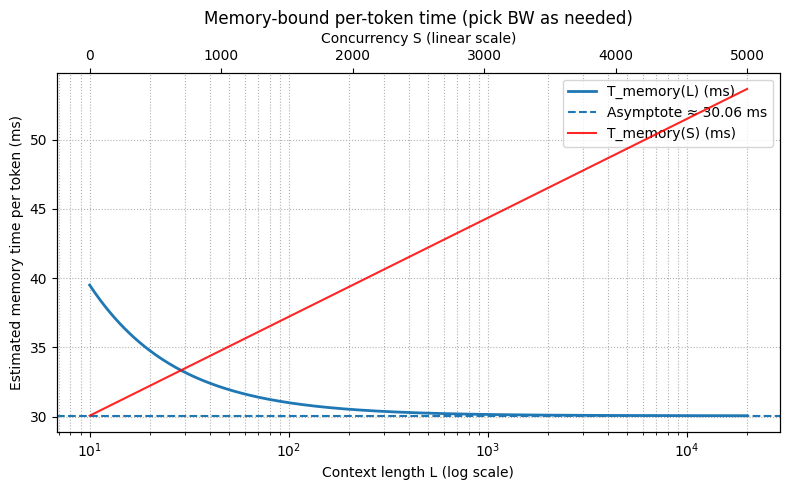

In [ ]:

# Choose bandwidth: e.g. A100-80GB BW=2.0e12; for A100-40GB set BW=1.555e12
L_vals = np.logspace(np.log10(10), np.log10(P), 400)
S_vals = np.linspace(1, 5000, 400)

Tmem_L = np.array([T_memory_of_L(L, P, d, r, n_layers, dtype_bytes, BW) for L in L_vals])
Tmem_S = np.array([T_memory_of_S(S, P, d, r, n_layers, dtype_bytes, BW) for S in S_vals])

B_asym = (
    bytes_weights_per_model(d, r, n_layers, dtype_bytes) +
    bytes_kv_read_per_model(P, d, n_layers, dtype_bytes)
)
T_asym = B_asym / BW

fig, axL = plt.subplots(figsize=(8,5))
axL.plot(L_vals, Tmem_L*1e3, label="T_memory(L) (ms)", linewidth=2)
axL.axhline(T_asym*1e3, linestyle="--", label=f"Asymptote ≈ {T_asym*1e3:.2f} ms")
axL.set_xscale("log")
axL.set_xlabel("Context length L (log scale)")
axL.set_ylabel("Estimated memory time per token (ms)")
axL.grid(True, which="both", linestyle=":")

axS = axL.twiny()
axS.plot(S_vals, Tmem_S*1e3, label="T_memory(S) (ms)", alpha=0.85, color='red')
axS.set_xlabel("Concurrency S (linear scale)")

lines_L, labels_L = axL.get_legend_handles_labels()
lines_S, labels_S = axS.get_legend_handles_labels()
axL.legend(lines_L + lines_S, labels_L + labels_S, loc="upper right")

plt.title("Memory-bound per-token time (pick BW as needed)")
plt.tight_layout()
plt.show()



## Sample Points

A small table of representative $(L,S)$ values to validate magnitudes.


In [ ]:

# from caas_jupyter_tools import display_dataframe_to_user

rows = []
for L in [50, 200, 1000, 4000, 20000]:
    S = P / L
    rows.append({
        "L": L,
        "S": S,
        "Bytes_weights_GB": bytes_weights_per_model(d, r, n_layers, dtype_bytes)/1e9,
        "Bytes_KV_read_GB": bytes_kv_read_per_model(P, d, n_layers, dtype_bytes)/1e9,
        "Bytes_KV_write_GB": bytes_kv_write_per_model(S, d, n_layers, dtype_bytes)/1e9,
        "Bytes_act_IO_GB": bytes_activation_rw_per_model(S, d, n_layers, dtype_bytes)/1e9,
        "T_mem_ms": T_memory_of_L(L, P, d, r, n_layers, dtype_bytes, BW)*1e3
    })

df = pd.DataFrame(rows)
# display_dataframe_to_user("Memory-bound per-token time: sample points", df)
df

,L,S,Bytes_weights_GB,Bytes_KV_read_GB,Bytes_KV_write_GB,Bytes_act_IO_GB,T_mem_ms
0,50,400.0,25.769804,20.97152,0.419430,2.516582,31.946840
1,200,100.0,25.769804,20.97152,0.104858,0.629146,30.530757
2,1000,20.0,25.769804,20.97152,0.020972,0.125829,30.153135
3,4000,5.0,25.769804,20.97152,0.005243,0.031457,30.082331
4,20000,1.0,25.769804,20.97152,0.001049,0.006291,30.063449


#combine memory and bandwidth time

In [ ]:
# Install plotly if needed
!pip install plotly

In [ ]:
import numpy as np
import plotly.graph_objs as go

# Parameters
r = 4
d = 4096
n_layers = 64
gpu_flops_per_sec = 312e12   # 312 TFLOPS
dtype_bytes = 2
BW = 2.0e12  # 2 TB/s for A100-80GB (set to 1.555e12 for 40GB)

# Compute-bound FLOPs per token (no P constraint)
def T_compute(S, L, d=d, r=r, n_layers=n_layers, gpu=gpu_flops_per_sec):
    flops = n_layers * ((4+2*r)*d**2 + 2*L*d) * S
    return flops / gpu

# Memory-bound time per token (no P constraint)
def T_memory(S, L, d=d, r=r, n_layers=n_layers, dtype_bytes=dtype_bytes, BW=BW, c_act=12):
    B = (
        n_layers*(4+2*r)*d**2*dtype_bytes +    # weights
        n_layers*(2*L*d)*dtype_bytes*S +       # KV read (now scales with S*L, not fixed P)
        n_layers*(2*d)*dtype_bytes*S +         # KV write
        n_layers*(c_act*d)*dtype_bytes*S       # activations
    )
    return B / BW

# Define grid
S_vals = np.linspace(1, 1000, 50)
L_vals = np.linspace(10, 20000, 100)
S_grid, L_grid = np.meshgrid(S_vals, L_vals)

Tcomp = T_compute(S_grid, L_grid)
Tmem = T_memory(S_grid, L_grid)
T_total = np.maximum(Tcomp, Tmem)

# Plot compute surface
fig1 = go.Figure(data=[go.Surface(z=Tcomp, x=S_grid, y=L_grid)])
fig1.update_layout(title="T_compute(S,L)", scene=dict(
    xaxis_title="S (concurrency)",
    yaxis_title="L (context length)",
    zaxis_title="Time (s)"
))
fig1.show()

# Plot memory surface
fig2 = go.Figure(data=[go.Surface(z=Tmem, x=S_grid, y=L_grid)])
fig2.update_layout(title="T_memory(S,L)", scene=dict(
    xaxis_title="S (concurrency)",
    yaxis_title="L (context length)",
    zaxis_title="Time (s)"
))
fig2.show()

# Plot total time  surface
fig3 = go.Figure(data=[go.Surface(z=T_total, x=S_grid, y=L_grid)])
fig3.update_layout(title="T_total(S,L) ~ max(Tmem, Tcomp)", scene=dict(
    xaxis_title="S (concurrency)",
    yaxis_title="L (context length)",
    zaxis_title="Time (s)"
))
fig3.show()

In [ ]:
# citing from flash2.pdf

Benchmark setting: we vary the sequence length from 512, 1k, ..., 16k, and set batch size so that the total
number of tokens is 16k. We set hidden dimension to 2048, and head dimension to be either 64 or 128 (i.e.,
32 heads or 16 heads). To calculate the FLOPs of the forward pass, we use:
4 · seqlen2 · head dimension · number of heads.